In [2]:
import numpy as np
from scipy.signal import periodogram
from scipy.stats import norm
import matplotlib.pyplot as plt

In [3]:
# message to be transmitted
# msg = np.array([0, 1, 0, 0, 1, 1, 0, 1, 1, 0])
msg = np.random.randint(low=0, high=2, size=int(1e6))
# print(msg)

In [4]:
# Carrier signal
f_c = 100.0
t_c = 1.0/f_c

# Sampling rate
f_s = 10000.0
t_s = 1.0/f_s

# QPSK Parameters
Tb = 0.01
Eb = 0.001

In [5]:
# Time vector
# t = np.arange(0.0, t_c, t_s)
t = np.linspace(0.0, Tb, int(Tb*f_s))

# Serial to parallel with k=2 (QPSK)
symbols = np.array([msg[0::2], msg[1::2]])
print(symbols)

[[1 1 0 ... 0 1 1]
 [1 0 1 ... 1 1 1]]


In [6]:
theta = np.zeros(np.size(symbols, axis=1), dtype='float')
for k in range(np.size(symbols, axis=1)):
    b_0 = symbols[0,k]
    b_1 = symbols[1,k]
    # Page 8, Lecture 16
    if b_0 == 0 and b_1 == 0:
        theta[k] = 7.0*np.math.pi/4.0
    elif b_0 == 0 and b_1 == 1:
        theta[k] = 5.0*np.math.pi/4.0
    elif b_0 == 1 and b_1 == 1:
        theta[k] = 3.0*np.math.pi/4.0
    elif b_0 == 1 and b_1 == 0:
        theta[k] = np.math.pi/4.0

In [7]:
# A = 1.0
A = np.sqrt(Eb)
I = A*np.cos(theta)  # in-phase component
Q = A*np.sin(theta)  # quadrature component

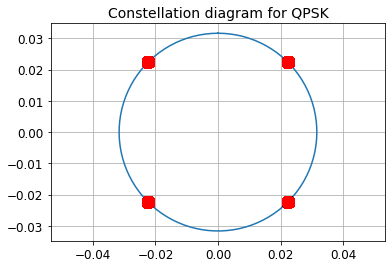

In [8]:
plt.figure()
plt.axes().set_aspect('equal', 'datalim') # Makes it look like a circle instead of an ellipse

# Time vector for sine and cosine
t_csd = np.linspace(0.0, 2.0*np.math.pi, 100)
plt.plot(np.sqrt(Eb)*np.sin(t_csd), np.sqrt(Eb)*np.cos(t_csd)) # sqrt(Eb)*sin and sqrt(Eb)*cos
plt.plot(I, Q, "ro", markersize=12)
plt.grid()

plt.title("Constellation diagram for QPSK", fontsize=14)
plt.tick_params(labelsize=12)
plt.show()

In [9]:
modulated_signal = np.zeros(np.size(symbols, axis=1)*len(t), dtype='float')
phi_1 = np.sqrt(2/Tb)*np.cos(2.0*np.math.pi*f_c*t)
phi_2 = np.sqrt(2/Tb)*np.sin(2.0*np.math.pi*f_c*t)
for k in range(np.size(symbols, axis=1)):
    # Calculates modulated signal for each symbol
    # Page 12, Lecture 16
    modulated_signal[k*len(t):(k+1)*len(t)] = I[k]*phi_1 - Q[k]*phi_2
# print(modulated_signal)

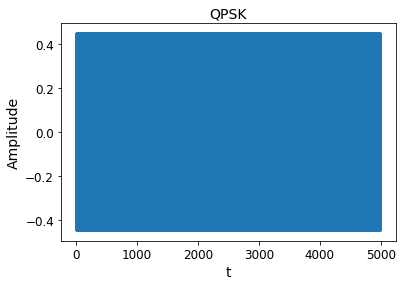

In [10]:
# Time vector for symbols
# t_sym = np.arange(0.0, np.size(symbols, axis=1)*2.0*t_c, t_s)
t_sym = np.linspace(0, np.size(symbols, axis=1)*Tb, int(np.size(symbols, axis=1)*Tb*f_s))
# print(t_sym)
# print(np.size(t_sym, axis=0))

plt.figure()

plt.title("QPSK", fontsize=14)
plt.xlabel("t", fontsize=14)
plt.ylabel("Amplitude", fontsize=14)
plt.tick_params(labelsize=12)

plt.plot(t_sym, modulated_signal)
plt.show()

In [11]:
# Noise
ns = len(modulated_signal)
noise = np.random.normal(size=ns)

f, psd = periodogram(noise, f_s)

# fig, ax = plt.subplots(2,1)
# ax[0].plot(noise)
# ax[1].plot(f, psd)

psd_av = np.mean(psd)
N0 = 2*psd_av
modulated_signal += noise
print(N0)

0.00039988567475363854


In [12]:
t = np.linspace(0, Tb, int(Tb*f_s))
phi_1 = np.sqrt(2/Tb)*np.cos(2.0*np.math.pi*f_c*t)
phi_2 = np.sqrt(2/Tb)*np.sin(2.0*np.math.pi*f_c*t)
N = len(modulated_signal) // len(t)
split_modulated_signal = np.array_split(modulated_signal, N)
received_symbols = [[] for i in range(2)]
for i in split_modulated_signal:
    s_1 = i*phi_1
    s_2 = i*phi_2
    x = s_1.sum()/f_s
    y = s_2.sum()/f_s
    if x > 0 and y > 0:
        received_symbols[0].append(0)
        received_symbols[1].append(0)
    elif x < 0 and y > 0:
        received_symbols[0].append(0)
        received_symbols[1].append(1)
    elif x < 0 and y < 0:
        received_symbols[0].append(1)
        received_symbols[1].append(1)
    elif x > 0 and y < 0:
        received_symbols[0].append(1)
        received_symbols[1].append(0)

In [13]:
received_msg = []
for i in range(len(received_symbols[0])):
    for j in range(len(received_symbols)):
        received_msg.append(received_symbols[j][i])

In [14]:
np.array(received_msg), msg

(array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]))

In [15]:
# Bit Error Probability Calculations
Pb = norm.sf(np.sqrt(2*Eb/N0))
print('Theoretical Bit Error Probability:', Pb)
Pb_pr = np.count_nonzero(msg != received_msg) / len(msg)
print('Practical Bit Error Probability:', Pb_pr)

Theoretical Bit Error Probability: 0.012663196514264376
Practical Bit Error Probability: 0.012763


In [16]:
# Symbol Error Probability Calculations
k = 2
M = 2**k
Pe = 2*norm.sf(np.sqrt(2*k*Eb/N0)*np.sin(np.math.pi/M))
Pb = Pe/k
print(Pe, Pb)

0.02532639302852875 0.012663196514264376
